In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob

In [2]:
def get_rank(obs_ds, ensemble_ds):

    # The rank histogram is a distribution of observation rank within the ensemble
    # so to caculate it we need to know the rank of each observation at each time
    # step. We can do this by sorting the ensemble values at each time step and
    # then finding the index of the observation value within the sorted ensemble
    # values. This index should then be saved to a list.

    # First we need to parse the observation file to separate each of the observation
    # types into their own data set. This will make it easier to work with the data. 

    obs_parsed = parse_obs_netcdf(obs_ds) # this is a list of data sets 

    # Now we need to loop through each of the observation types and calculate the rank.

    name_pairs = {'SAT_SEAICE_AGREG_CONCENTR':'aice', 'SAT_SEAICE_AGREG_THICKNESS':'hi', 
                  'SAT_SEAICE_AICE01':'aice1',  'SAT_SEAICE_AICE02':'aice2',
                  'SAT_SEAICE_AICE03':'aice3',  'SAT_SEAICE_AICE04':'aice4',
                  'SAT_SEAICE_AICE05':'aice5',  'SAT_SEAICE_AGREG_FREEBOARD':'fb'} 

    OBS_RANKS = []
    for name in obs_parsed.obs_name:
        var = name_pairs[name.item()]
        count = 0
        RANK = []
        for i in ds.time:
            members = ds[var].sel({'time':i}).values.tolist()

            obs = obs_parsed.sel({'obs_name': name.item()})[count].values.item()

            members.append(obs)
            sorted_members = sorted(members)

            obs_rank = sorted_members.index(obs) + 1
            RANK.append(obs_rank)
            count += 1
        
        rank = xr.DataArray(RANK, dims={'time'}, coords={'time':ds.time, 'obs_name':name})
        OBS_RANKS.append(rank)

    ranks = xr.concat(OBS_RANKS, dim = 'obs_name')

    return ranks


def parse_obs_netcdf(obs_ds):

    OBS = []
    for ob_ind in list(np.unique(obs_ds.obs_type)):
        t = obs_ds.where(obs_ds.obs_type == ob_ind, drop=True)

        obs = t.observations.sel({'copy':1}).drop('ObsIndex')

        # get the observation type name
        name = obs_ds.ObsTypesMetaData.where(obs_ds.ObsTypes == ob_ind, drop=True).values[0]
        obs['obs_name'] = name.strip().decode('utf-8')

        OBS.append(obs)
    
    obs_ds = xr.concat(OBS, dim='obs_name')

    return obs_ds


def freeboard_operator(ds):

    # calculate freeboard from the ice thickness and the snow depth

    ice_dens = 917.0
    snow_dens = 330.0
    water_dens = 1026.0

    ice_volume = ds.vice
    snow_volume = ds.vsnon.sum(dim='ncat')

    fb_volume = ice_volume * (1-ice_dens/water_dens) - snow_volume * snow_dens/water_dens

    fb = fb_volume / ds.aice 

    ds['fb'] = fb

    return ds

In [3]:
case = 'free_SHEBA'
files = sorted(glob.glob('/glade/scratch/mollyw/ICEPACK_RUNS/'+case+'/mem*/history/*.nc'))

DS = []
for file in files:
    dds = xr.open_dataset(file)
    DS.append(dds.sel(time=slice('2011-01-02','2011-12-31')).isel({'ni':2})[['vice','aice','vicen','aicen','vsnon']])
ds = xr.concat(DS, dim='ensemble_member')
ds = ds.resample(time='1D').mean()

ds['hi'] = ds.vice/ds.aice
ds = freeboard_operator(ds)


In [4]:
obs = xr.open_dataset('/glade/u/home/mollyw/work/Projects/cice-scm-da/data/processed/synthetic_obs/free_test/netcdfs/aggregate_observations.nc')

Calculate rank of the observation relative to each ensemble member

In [5]:
ranks = get_rank(obs, ds)

Plot the histograms by variable

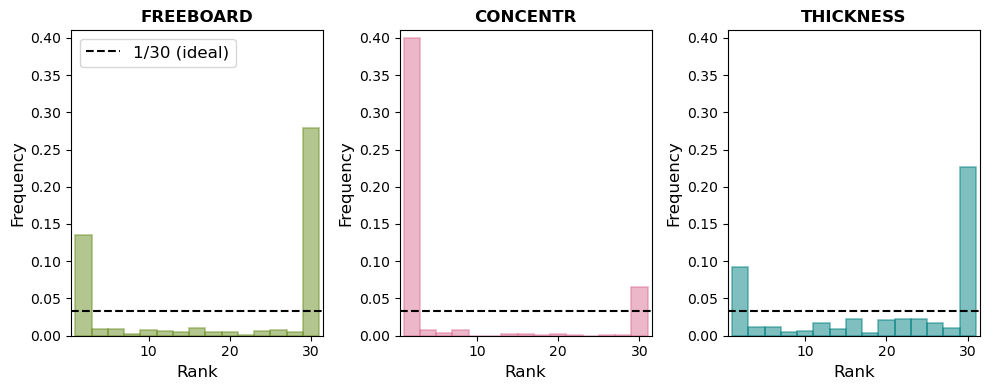

In [6]:
fig, axes = plt.subplots(ncols = 3, figsize=(10,4))

count = 0
var_colors = {'SAT_SEAICE_AGREG_FREEBOARD': 'olivedrab','SAT_SEAICE_AGREG_CONCENTR':'palevioletred', 'SAT_SEAICE_AGREG_THICKNESS':'teal',}
for n in ranks.obs_name:
    axes[count].hist(ranks.sel({'obs_name':n}), bins=15, density=True, 
                     color = var_colors[n.item()], alpha=0.5, edgecolor=var_colors[n.item()],
                     linewidth=1.2)
    axes[count].set_title(n.item()[17:], fontweight='bold', fontsize=12)
    axes[count].set_xlabel('Rank', fontsize=12)
    axes[count].set_ylabel('Frequency', fontsize=12)
    axes[count].set_xlim(0.5,31.5)
    axes[count].set_ylim(0,0.41)
    axes[count].hlines(1/30, 0.5, 31.5, color='k', linestyle='--', label = '1/30 (ideal)')
    count += 1

axes[0].legend(loc='upper left', fontsize=12)
plt.tight_layout()

plt.savefig('figures/'+case+'_rank_histogram.png', dpi=300, bbox_inches='tight')

Compare to an assimilated case